In [1]:
import pandas as pd
from scipy import linalg
from sklearn.cluster import KMeans
from rtree import index
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations

k_means_low = 2
k_means_high = 20
threshold = 17
search = True

# Load data here
print("=== Loading data ===")

df = pd.read_table('t4.8k.dat',
                   delim_whitespace=True,
                   index_col=None,
                   header=None)

print("=== Data loaded ===")

=== Loading data ===
=== Data loaded ===


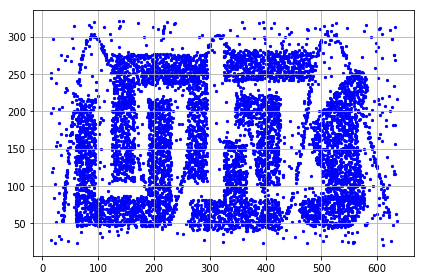

In [2]:
# Show the input data
plt.scatter(df[0], df[1], 
            c='blue', marker='o', 
            s=5)
plt.grid()
plt.tight_layout()
#plt.savefig('./original.png', dpi=300)
plt.show()

In [3]:
X = df.as_matrix()

print("=== Initializing data ===")

frequency = dict()
for i in range(len(X)):
    frequency[i] = dict()
    for j in range(i+1, len(X)):
        frequency[i][j] = 0
print("=== Initializing data ===")

=== Initializing data ===
=== Initializing data ===


In [4]:
# do clustering
print("=== Start Clustering ===")
for k in range(k_means_low, k_means_high+1):
    
    print("Starting clustering: k-means -- k={}"
          .format(str(k)))
    
    km = KMeans(n_clusters=k, 
                init='k-means++', 
                random_state=0).fit(X)
    
    Y = km.labels_
    
    print("Storing the result...")
    
    # update the frequency list
    for i in range(k):
        loc = np.where(Y == i)[0]
        
        for j, s in combinations(loc, 2):
            frequency[j][s] += 1
            
    print("k-means -- k={} complete"
          .format(str(k)))
    
print("=== Complete Clustering ===")

=== Start Clustering ===
Starting clustering: k-means -- k=2
Storing the result...
k-means -- k=2 complete
Starting clustering: k-means -- k=3
Storing the result...
k-means -- k=3 complete
Starting clustering: k-means -- k=4
Storing the result...
k-means -- k=4 complete
Starting clustering: k-means -- k=5
Storing the result...
k-means -- k=5 complete
Starting clustering: k-means -- k=6
Storing the result...
k-means -- k=6 complete
Starting clustering: k-means -- k=7
Storing the result...
k-means -- k=7 complete
Starting clustering: k-means -- k=8
Storing the result...
k-means -- k=8 complete
Starting clustering: k-means -- k=9
Storing the result...
k-means -- k=9 complete
Starting clustering: k-means -- k=10
Storing the result...
k-means -- k=10 complete
Starting clustering: k-means -- k=11
Storing the result...
k-means -- k=11 complete
Starting clustering: k-means -- k=12
Storing the result...
k-means -- k=12 complete
Starting clustering: k-means -- k=13
Storing the result...
k-means 

In [5]:
number_of_clusters = 0
print("===Finding stable clusters with threshold = {}===".format(threshold))
print("This may take one to two minutes...")
labels = [0 for x in range(len(X))]
for i in range(len(X)):
    # Check if a point is labeled
    if labels[i] == 0:
        # If not labeled, check if the point is clustered with other points
        # above a specified number of times
        neighborhood = list()
        for j in range(i+1, len(X)):
            if frequency[i][j] >= threshold:
                neighborhood.append(j)
        
        # If there is more than one point found, that means a "stable cluster"
        # is found. Label such point.
        if len(neighborhood) > 0:
            number_of_clusters += 1
            labels[i] = number_of_clusters
            
            Q = set(neighborhood)
            
            # Expand the cluster, find transitive closure
            while(len(Q)>0):
                current = Q.pop()
                labels[current] = number_of_clusters
                
                # Find if point [0, ..., current-1] appears in the current cluster for more than
                # `threshold` number of times
                for j in range(current):
                    if labels[j] == 0 and frequency[j][current] >= threshold:
                        Q.add(j)
                
                # Find if point [current+1, ..., end] appears in the current cluster for more than
                # `threshold` number of times
                for j in range(current+1, len(X)):
                    if labels[j] == 0 and frequency[current][j] >= threshold:
                        Q.add(j)

===Finding stable clusters with threshold = 17===
This may take one to two minutes...


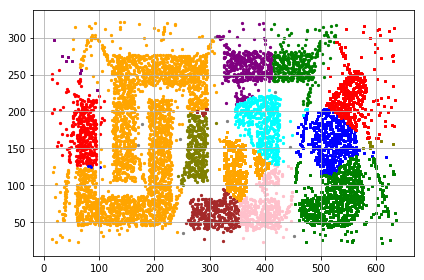

Outliers (does not meet threshold with any other data point) are shown in gray


In [6]:
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "olive", "cyan"]
markers = ["o", "s", "p", "*", "^", "8", "D"]
labels = np.asarray(labels)
plt.scatter(df[0][labels==0], df[1][labels==0], c='gray', marker='o', s=5)

for i in range(1, number_of_clusters+1):
    plt.scatter(df[0][labels==i], df[1][labels==i], c=colors[i%9], marker=markers[int(i/9)%7], s=5)

plt.grid()
plt.tight_layout()
plt.savefig('./result.png', dpi=300)
plt.show()
print("Outliers (does not meet threshold with any other data point) are shown in gray")

if(number_of_clusters > len(colors)*len(markers)):
    print("Warning: some clusters are represented by the same color and marker, please reduce number of clusters or modify the plotting code")

In [7]:
##########
#Optional#
##########
# Determine the threshold

# The following code explores the threshold decremently from 
# the number of possible clusters down to 1. It will stop at
# the point where the scatter plot can be done using one 
# marker with various colors. In this example, the number of
# possible colors is 9.
if search:
    for th in range(k_means_high-k_means_low+1, 0, -1):
        number_of_clusters = 0
        print("Finding stable clusters with threshold = {}".format(th))
        print("This may take one to two minutes...")
        labels = [0 for x in range(len(X))]
        for i in range(len(X)):
            # Check if a point is labeled
            if labels[i] == 0:
                # If not labeled, check if the point is clustered with other points
                # above a specified number of times
                neighborhood = list()
                for j in range(i+1, len(X)):
                    if frequency[i][j] >= th:
                        neighborhood.append(j)

                # If there is more than one point found, that means a "stable cluster"
                # is found. Label such point.
                if len(neighborhood) > 0:
                    number_of_clusters += 1
                    labels[i] = number_of_clusters

                    Q = set(neighborhood)

                    # Expand the cluster, find transitive closure
                    while(len(Q)>0):
                        current = Q.pop()
                        labels[current] = number_of_clusters

                        # Find if point [0, ..., current-1] appears in the current cluster for more than
                        # `threshold` number of times
                        for j in range(current):
                            if labels[j] == 0 and frequency[j][current] >= th:
                                Q.add(j)

                        # Find if point [current+1, ..., end] appears in the current cluster for more than
                        # `threshold` number of times
                        for j in range(current+1, len(X)):
                            if labels[j] == 0 and frequency[current][j] >= th:
                                Q.add(j)
        print("*** Summary for threshold - {} ***".format(th))
        print("Number of clusters: ", number_of_clusters)
        print("Data size: ", len(labels))
        print("Data points covered: ", len(labels)-list(labels).count(0))
        print("Number of outliers: ", list(labels).count(0))
        if number_of_clusters > len(colors)*len(markers):
            print(">> This cannot be properly plotted due to the number of colors and markers.")
        if number_of_clusters <= len(colors):
            print(">> This can be plotted by using one marker with different colors.")
            print(">> The finding process will stop now.")
            break

Finding stable clusters with threshold = 19
This may take one to two minutes...
*** Summary for threshold - 19 ***
Number of clusters:  272
Data size:  8000
Data points covered:  7841
Number of outliers:  159
>> This cannot be properly plotted due to the number of colors and markers.
Finding stable clusters with threshold = 18
This may take one to two minutes...
*** Summary for threshold - 18 ***
Number of clusters:  51
Data size:  8000
Data points covered:  7964
Number of outliers:  36
Finding stable clusters with threshold = 17
This may take one to two minutes...
*** Summary for threshold - 17 ***
Number of clusters:  19
Data size:  8000
Data points covered:  7991
Number of outliers:  9
Finding stable clusters with threshold = 16
This may take one to two minutes...
*** Summary for threshold - 16 ***
Number of clusters:  3
Data size:  8000
Data points covered:  7998
Number of outliers:  2
>> This can be plotted by using one marker with different colors.
>> The finding process will sto